In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from deepctr.inputs import SparseFeat, VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM
import warnings 
warnings.filterwarnings('ignore')

In [2]:

data = pd.read_csv("ml-100k.csv")
sparse_features = ["movie_id", "user_id", "gender", "age", "occupation", "zip_code", ]
target = ['rating']

In [3]:
def split(x):
    key_ans = str(x).split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [4]:

# 1.Label Encoding for sparse features,and process sequence features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

In [5]:
key2index ={}
genres_list = list(map(split, data['genre'].values))
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)
# Notice : padding=`post`
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', )

In [6]:
genres_list

array([[ 1,  0,  0,  0,  0,  0],
       [ 2,  3,  4,  0,  0,  0],
       [ 2,  1,  5,  0,  0,  0],
       ...,
       [ 1,  9,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0],
       [12,  6,  0,  0,  0,  0]])

In [7]:
# 2.count #unique features for each sparse field and generate feature config for sequence feature
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(), embedding_dim=4)
                      for feat in sparse_features]

use_weighted_sequence = False
if use_weighted_sequence:
    varlen_feature_columns = [ VarLenSparseFeat(SparseFeat('genre',
                                vocabulary_size=len(key2index) + 1,
                                embedding_dim=4),
                                maxlen=max_len,
                                combiner='mean',
                                weight_name='genres_weight')]  # Notice : value 0 is for padding for sequence input feature
else:
    varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genre', 
                                   vocabulary_size=len(key2index) + 1,
                                    embedding_dim=4),
                                    maxlen=max_len, 
                                    combiner='mean',
                                    weight_name=None)]  # Notice : value 0 is for padding for sequence input feature

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)


In [8]:
feature_names

['movie_id', 'user_id', 'gender', 'age', 'occupation', 'zip_code', 'genre']

In [9]:

# 3.generate input data for model
model_input = {name: data[name].values for name in sparse_features}  #
model_input["genre"] = genres_list
# model_input["genres_weight"] = np.random.randn(data.shape[0], max_len, 1)

In [10]:
model_input

{'movie_id': array([ 241,  301,  376, ..., 1089,  224,  202], dtype=int64),
 'user_id': array([195, 185,  21, ..., 275,  12,  11], dtype=int64),
 'gender': array([1, 0, 1, ..., 1, 1, 0]),
 'age': array([39, 29, 15, ..., 11, 37, 18], dtype=int64),
 'occupation': array([20,  6, 20, ..., 18,  3, 13]),
 'zip_code': array([415,   0, 311, ..., 715, 243,  58]),
 'genre': array([[ 1,  0,  0,  0,  0,  0],
        [ 2,  3,  4,  0,  0,  0],
        [ 2,  1,  5,  0,  0,  0],
        ...,
        [ 1,  9,  0,  0,  0,  0],
        [ 3,  0,  0,  0,  0,  0],
        [12,  6,  0,  0,  0,  0]])}

In [11]:
# 4.Define Model,compile and train
model = DeepFM(linear_feature_columns,
               dnn_feature_columns,
               task='regression')

model.compile(optimizer = "adam", loss =  "mse", metrics=['mse'], )
history = model.fit(model_input,
                    data[target].values,
                    batch_size=512, 
                    epochs=15, 
                    verbose=2, 
                    validation_split=0.2 )

Train on 80000 samples, validate on 20000 samples
Epoch 1/15
80000/80000 - 3s - loss: 2.9471 - mse: 2.9470 - val_loss: 0.9100 - val_mse: 0.9099
Epoch 2/15
80000/80000 - 1s - loss: 0.8839 - mse: 0.8837 - val_loss: 0.8816 - val_mse: 0.8814
Epoch 3/15
80000/80000 - 1s - loss: 0.8653 - mse: 0.8651 - val_loss: 0.8768 - val_mse: 0.8766
Epoch 4/15
80000/80000 - 1s - loss: 0.8547 - mse: 0.8545 - val_loss: 0.8718 - val_mse: 0.8716
Epoch 5/15
80000/80000 - 1s - loss: 0.8385 - mse: 0.8382 - val_loss: 0.8590 - val_mse: 0.8587
Epoch 6/15
80000/80000 - 1s - loss: 0.8275 - mse: 0.8272 - val_loss: 0.8541 - val_mse: 0.8538
Epoch 7/15
80000/80000 - 1s - loss: 0.8205 - mse: 0.8202 - val_loss: 0.8589 - val_mse: 0.8586
Epoch 8/15
80000/80000 - 1s - loss: 0.8120 - mse: 0.8117 - val_loss: 0.8535 - val_mse: 0.8532
Epoch 9/15
80000/80000 - 1s - loss: 0.8040 - mse: 0.8037 - val_loss: 0.8493 - val_mse: 0.8490
Epoch 10/15
80000/80000 - 1s - loss: 0.7944 - mse: 0.7940 - val_loss: 0.8460 - val_mse: 0.8456
Epoch 11/

In [12]:
import matplotlib.pyplot as plt 
%matplotlib inline  

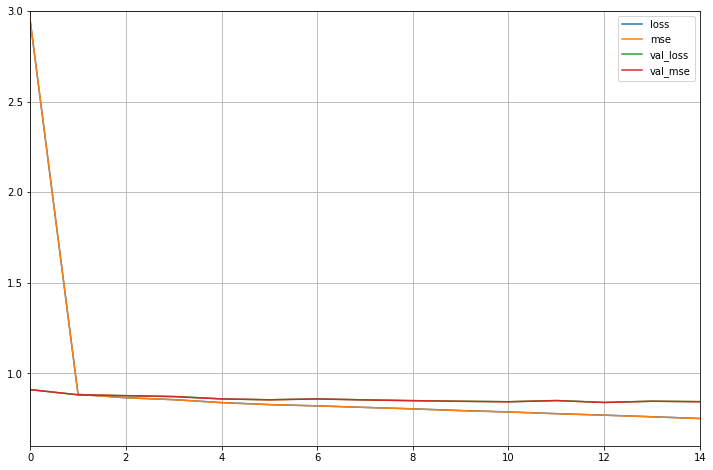

In [13]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(12, 8))
    plt.grid(True)
    plt.gca().set_ylim(0.6,3)
    plt.show()
plot_learning_curves(history)

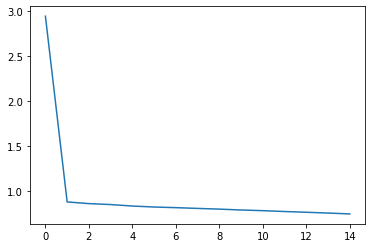

In [14]:
plt.plot( history.history['loss'])

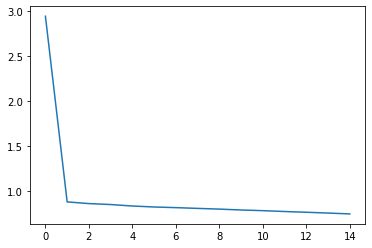

In [15]:
plt.plot( history.history['mse'])

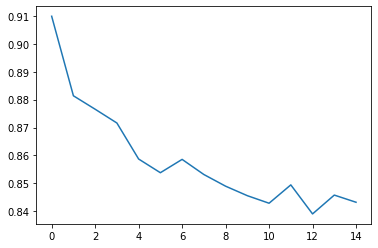

In [16]:
plt.plot( history.history['val_mse'])